In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -q -U  transformers==2.8.0
!pip install -q -U  torch==1.4.0
!pip install -q -U  pandas==1.0.3


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.0.3
torch       : 1.4.0
transformers: 2.8.0



In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/sample_data/reviews.csv")
df.head()

,userName,content,score,at,sortOrder,appId
0,ersle,love u guys r best,2,Mon Apr 06 22:22:45 PDT 2009,most_relevant,com.anydo
1,becca210,im meeting one besties tonight cant wait girl ...,1,Mon Apr 06 22:22:45 PDT 2009,most_relevant,com.anydo
2,Wingman29,darealsunisakim thanks twitter add sunisa got ...,2,Mon Apr 06 22:22:46 PDT 2009,most_relevant,com.anydo
3,katarinka,sick really cheap hurts much eat real food plu...,0,Mon Apr 06 22:22:46 PDT 2009,most_relevant,com.anydo
4,_EmilyYoung,effect everyone,2,Mon Apr 06 22:22:46 PDT 2009,most_relevant,com.anydo


In [ ]:
print(df.shape[0])

16000


In [ ]:
df['sentiment'] = df.score

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [94]:
sample_txt = 'This is the final project'

In [95]:
print('Tokenized: ', tokenizer.tokenize(sample_txt))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample_txt)))

Tokenized:  ['This', 'is', 'the', 'final', 'project']
Token IDs:  [1188, 1110, 1103, 1509, 1933]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, 
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
MAX_LEN = 160

In [ ]:
import torch
from torch.utils.data import Dataset
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:

from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(df,test_size=0.1)
val_set, test_set = train_test_split(test_set,test_size=0.5)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

training_data_loader = create_data_loader(training_set, tokenizer, MAX_LEN, BATCH_SIZE)
validation_data_loader = create_data_loader(val_set, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_set, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
tr_data = next(iter(training_data_loader))
tr_data.keys()
print(tr_data['input_ids'].shape)
print(tr_data['attention_mask'].shape)
print(tr_data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
from transformers import BertModel
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])

In [ ]:

print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


In [ ]:
from torch import nn
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = tr_data['input_ids'].to(device)
attention_mask = tr_data['attention_mask'].to(device)


In [ ]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5286, 0.2926, 0.1788],
        [0.5501, 0.1969, 0.2531],
        [0.5243, 0.1346, 0.3411],
        [0.4526, 0.2890, 0.2584],
        [0.6182, 0.1464, 0.2353],
        [0.4685, 0.1866, 0.3449],
        [0.7250, 0.1190, 0.1560],
        [0.6302, 0.1935, 0.1763],
        [0.3562, 0.1919, 0.4519],
        [0.4823, 0.2225, 0.2952],
        [0.5680, 0.1676, 0.2645],
        [0.5982, 0.1279, 0.2739],
        [0.5443, 0.2048, 0.2509],
        [0.3485, 0.1567, 0.4948],
        [0.5565, 0.1509, 0.2926],
        [0.7288, 0.1133, 0.1579]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [ ]:

from transformers import AdamW,get_linear_schedule_with_warmup
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(training_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    

    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
torch.cuda.empty_cache()

In [ ]:

#%%time

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model = model,loss_fn = loss_fn,data_loader= training_data_loader, optimizer= optimizer, device = device,scheduler =  scheduler, n_examples = training_set.shape[0])

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, validation_data_loader, loss_fn, device, len(val_set))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.7299162580735153 accuracy 0.6620138888888889
Val   loss 0.5537388148903847 accuracy 0.7475

Epoch 2/5
----------
Train loss 0.43312570598390365 accuracy 0.8210416666666667
Val   loss 0.5248091004788875 accuracy 0.77375

Epoch 3/5
----------
Train loss 0.2759914354566071 accuracy 0.9016666666666666
Val   loss 0.6829432885348797 accuracy 0.78125

Epoch 4/5
----------
Train loss 0.19387446127004093 accuracy 0.9420138888888889
Val   loss 0.9120258605480194 accuracy 0.80125

Epoch 5/5
----------


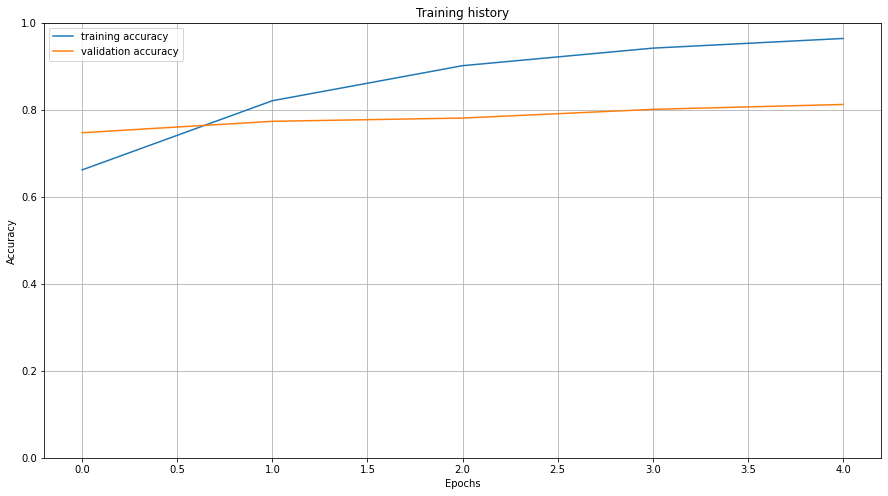

In [93]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(history['train_acc'], label='training accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.ylim([0, 1]);

In [45]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [46]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

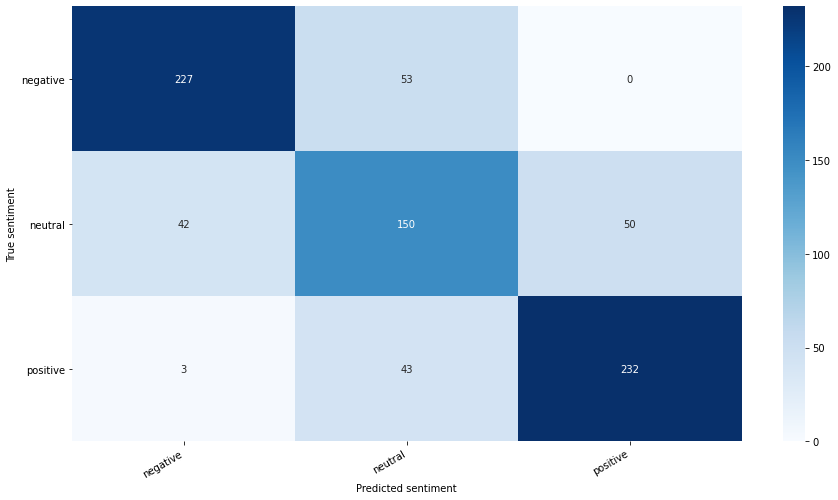

In [47]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cnf_mtrx = confusion_matrix(y_test, y_pred)
df_cnf_mtrx = pd.DataFrame(cnf_mtrx, index=class_names, columns=class_names)
show_confusion_matrix(df_cnf_mtrx)

In [39]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [42]:
torch.save(model,'/content/sample_data/bert_model.pt')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SentimentClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
pred_tesla = []
twitter_data_tesla = pd.read_csv("/content/Twitter_data_tesla.csv")
text = twitter_data_tesla['Text']
for line in text:
  encoded_review = tokenizer.encode_plus(line,max_length=MAX_LEN,add_special_tokens=True,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt')
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred_tesla.append(prediction)

twitter_data_tesla['sentiment'] = pred_tesla
x=twitter_data_tesla['sentiment']
for i in range(5,len(x)):
  x[i]=x[i].cpu().detach().numpy()
twitter_data_tesla['sentiment'] = x  
twitter_data_tesla['sentiment'] = twitter_data_tesla['sentiment'].apply(lambda x : int(x))

In [51]:
pred_google = []
twitter_data_google = pd.read_csv("Twitter_data_Google.csv")
text = twitter_data_google['Text']
for line in text:
  encoded_review = tokenizer.encode_plus(line,max_length=MAX_LEN,add_special_tokens=True,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt')
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred_google.append(prediction)
twitter_data_google['sentiment']= pred_google
x=twitter_data_google['sentiment']
for i in range(5,len(x)):
  x[i]=x[i].cpu().detach().numpy()
twitter_data_google['sentiment'] = x  
twitter_data_google['sentiment'] = twitter_data_google['sentiment'].apply(lambda x : int(x))

In [ ]:
pred_apple = []
twitter_data_apple = pd.read_csv("Twitter_data_Apple.csv")
text = twitter_data_apple['Text']
for line in text:
  encoded_review = tokenizer.encode_plus(line,max_length=MAX_LEN,add_special_tokens=True,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt')
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred_apple.append(prediction)

twitter_data_apple['sentiment'] = pred_apple
x=twitter_data_apple['sentiment']
for i in range(5,len(x)):
  x[i]=x[i].cpu().detach().numpy()
twitter_data_apple['sentiment'] = x  
twitter_data_apple['sentiment'] = twitter_data_apple['sentiment'].apply(lambda x : int(x))

In [96]:
from datetime import datetime
column_names = ["Date",  "Google"]

df_final = pd.DataFrame(columns = column_names)

twitter_data_apple['Datetime'] = twitter_data_apple['Datetime'].apply(lambda x : x[0:10])
twitter_data_apple['Datetime'] = twitter_data_apple['Datetime'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
apple_final = twitter_data_apple.groupby('Datetime', as_index=False)['sentiment'].mean()

twitter_data_tesla['Datetime'] = twitter_data_tesla['Datetime'].apply(lambda x : x[0:10])
twitter_data_tesla['Datetime'] = twitter_data_tesla['Datetime'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
tesla_final = twitter_data_tesla.groupby('Datetime', as_index=False)['sentiment'].mean()

twitter_data_google['Datetime'] = twitter_data_google['Datetime'].apply(lambda x : x.strftime("%Y-%m-%d"))
twitter_data_google['Datetime'] = twitter_data_google['Datetime'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
google_final = twitter_data_google.groupby('Datetime', as_index=False)['sentiment'].mean()
df_final["Date"] = google_final['Datetime']
df_final["Tesla"] = tesla_final
df_final["Google"] = google_final["sentiment"]
df_final["Apple"] = apple_final
df_final.to_csv("sentiment.csv")

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)